In [16]:
!pip install torch==1.6.0
!pip install opencv-python
!pip install torchvision==0.7.0
!pip install albumentations
!pip install tensorflow
!pip install pytorch-lightning

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.9 MB 10.1 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.2.2
    Uninstalling torchvision-0.2.2:
      Successfully uninstalled torchvision-0.2.2
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.5 MB 1.2 MB/s 
     |████████████████████████████████| 2.9 MB 2.1 MB/s 
     |████████████████████████████████| 723 kB 4.7 MB/s 
     |████████████████████████████████| 883 kB 4.1 MB/s 
     |████████████████████████████████| 82 kB 1.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893258 sha256=012e87548fcdc737b5caae9fd67fb1363301bb419418474a742bf1e0c605ef0f
  Stored in directory: /home/user/.cache/pip/wheels/49/25/98/cdea9c79b2d9a22ccc59540b1784b67f06b633378e97f58da2
Successfully built sacremoses
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
!pip install torchlibrosa

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import cv2
import matplotlib.pyplot as plt
import time
import glob

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# import resnest.torch as resnest_torch

from torchvision import models
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation
# from mixup import do_mixup
import random
from timm.models.efficientnet import tf_efficientnet_b0_ns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# from resnet import ResNet, Bottleneck

from albumentations.core.transforms_interface import DualTransform, BasicTransform
import albumentations as A
from audiomentations import Compose, AddGaussianSNR, AddGaussianNoise, PitchShift, AddBackgroundNoise, AddShortNoises, Gain
from functools import partial


from sklearn.model_selection import StratifiedKFold

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## util

In [2]:
SEED=1213
PERIOD = 10
OK_RANGE = 100
SPECIES_NUM = 24
EPOCH = 50
OUTPUT_DIR = './output/'
HOP_LEN = 512
SR = 48000
EPSILON_FP16 = 1e-5
MEL_BIN = 384
ASOBI = 0

config_set = {
    'dataset': {
          'name': 'SpectrogramDataset',
          'params': {
            'img_size': 224, 
            'melspectrogram_parameters': {
                'n_fft': 2048,
                'hop_length': 512,
                'win_length': 2048,
                'n_mels': MEL_BIN, 
                'fmin': 50, 
                'fmax': 24000, 
            }
      }
    },
    'loader': {
      'train': {
        'batch_size': 6,
        'shuffle': True,
        'num_workers': 2,
        'pin_memory': True,
        'drop_last': True,
      },
      'valid': {
        'batch_size': 1,
        'shuffle': False,
        'num_workers': 2,
        'pin_memory': True,
        'drop_last': True,
      }
    }
}


In [3]:
config = config_set

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
set_seed(SEED)

In [5]:
INPUT_ROOT = Path("/home/knikaido/work/Rainforest-Connection/data")
RAW_DATA = INPUT_ROOT / "rfcx-species-audio-detection"
TRAIN_AUDIO_DIR = RAW_DATA / "train"
# TRAIN_RESAMPLED_AUDIO_DIRS = [
#   INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
# ]
TEST_AUDIO_DIR = RAW_DATA / "test"
pinknoise_dir = INPUT_ROOT / 'pinknoise_resample'

In [6]:
def get_augmentation():
    list_of_aug = [
    #         AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
        AddGaussianNoise(p=0.2),
        AddGaussianSNR(p=0.2),
        Gain(min_gain_in_db=-15,max_gain_in_db=15,p=0.3),
#         AddBackgroundNoise(str(pinknoise_dir),p=0.2),
#         AddShortNoises(str(pinknoise_dir),min_time_between_sounds=0.0, max_time_between_sounds=15.0, burst_probability=0.5, p=0.6)
    ]
    return Compose(list_of_aug)

In [7]:
train_df = pd.read_pickle(RAW_DATA / "train_gby_wav_raw_denoise.pkl")
train_df

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,name
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,/home/knikaido/work/Rainforest-Connection/data...
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,/home/knikaido/work/Rainforest-Connection/data...
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,/home/knikaido/work/Rainforest-Connection/data...
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,/home/knikaido/work/Rainforest-Connection/data...
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,/home/knikaido/work/Rainforest-Connection/data...
...,...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75,/home/knikaido/work/Rainforest-Connection/data...
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25,/home/knikaido/work/Rainforest-Connection/data...
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00,/home/knikaido/work/Rainforest-Connection/data...
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20,/home/knikaido/work/Rainforest-Connection/data...


In [8]:
train_gby = pd.read_pickle(RAW_DATA / "train_gby_denoise.pkl")
train_gby

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,name
0,003bec244,[14],[1],[44.544],[2531.25],[45.1307],[5531.25],/home/knikaido/work/Rainforest-Connection/data...
1,006ab765f,[23],[1],[39.9615],[7235.16],[46.0452],[11283.4],/home/knikaido/work/Rainforest-Connection/data...
2,007f87ba2,[12],[1],[39.135999999999996],[562.5],[42.272],[3281.25],/home/knikaido/work/Rainforest-Connection/data...
3,0099c367b,[17],[4],[51.4206],[1464.26],[55.1996],[4565.04],/home/knikaido/work/Rainforest-Connection/data...
4,009b760e6,[10],[1],[50.0854],[947.461],[52.5293],[10852.7],/home/knikaido/work/Rainforest-Connection/data...
...,...,...,...,...,...,...,...,...
1127,fe8d9ac40,[13],[1],[53.472],[93.75],[54.096000000000004],[843.75],/home/knikaido/work/Rainforest-Connection/data...
1128,fea6b438a,[4],[1],[43.5787],[2531.25],[45.7653],[4031.25],/home/knikaido/work/Rainforest-Connection/data...
1129,ff2eb9ce5,[0],[1],[15.2267],[5906.25],[16.0213],[8250.0],/home/knikaido/work/Rainforest-Connection/data...
1130,ffb8d8391,[5],[1],[14.3467],[4781.25],[16.6987],[10406.2],/home/knikaido/work/Rainforest-Connection/data...


In [9]:
def mono_to_color(
    X: np.ndarray, mean=None, std=None,
    norm_max=None, norm_min=None, eps=1e-6
):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [10]:
class SpectrogramTrainDataset(data.Dataset):
    def __init__(
        self,
        gby_df: pd.DataFrame,
        setting: tp.Dict
    ):
        self.img_size = setting['img_size']
        self.melspectrogram_parameters = setting['melspectrogram_parameters']
        self.transform = get_augmentation()
        
        self.gby_df = gby_df

    def __len__(self):
        return len(self.gby_df)

    def __getitem__(self, idx: int):
        
        wav_path = self.gby_df['name'][idx]
        train_element = self.gby_df.iloc[idx]
        
        y, sr = sf.read(wav_path)
    
        len_y = len(y)
        effective_length = int(sr * PERIOD)

        tmin = max(SR * (train_element['t_min'] - ASOBI), SR * 0.001)
        tmax = min(SR * (train_element['t_max'] + ASOBI), len_y - ( SR * 0.001 ))      
               
        start_min = max(0, tmax-effective_length)
        start_max = min(tmin, len_y - effective_length)
        start = np.random.randint(start_min, start_max)
        end = start + effective_length
                
#         start = int(max(0.0, min(tmin - (effective_length - tgt_len) / 2, min(tmax + (effective_length - tgt_len) / 2, len_y) - effective_length)))
        
        y = y[start:end].astype(np.float32)
        y = self.transform(samples=y, sample_rate=sr)
        
        label = np.zeros(SPECIES_NUM, dtype="f")
        label[train_element['species_id']] = 1

        return y, label
    
class SpectrogramValidDataset(data.Dataset):
    def __init__(
        self,
        gby_df: pd.DataFrame,
        setting: tp.Dict
    ):
        self.img_size = setting['img_size']
        self.melspectrogram_parameters = setting['melspectrogram_parameters']
        
        self.gby_df = gby_df

    def __len__(self):
        return len(self.gby_df)

    def __getitem__(self, idx: int):
        
        wav_path = self.gby_df['name'][idx]
        train_element = self.gby_df.iloc[idx]
        
        y, sr = sf.read(wav_path)
        
        len_y = len(y)
        effective_length = int(sr * PERIOD)

        tmin = int(SR * train_element['t_min'])
        tmax = int(SR * train_element['t_max'])
        
        #時間かかる
        while(1):
            start = np.random.randint(len_y - effective_length)
            end = start + effective_length
            tgt_len = int((tmax - tmin) * 100 / 100)
            if( (start < tmin and tmin + tgt_len < end) or (start < tmax - tgt_len and tmax < end) ):
                break
        
        y = y[start:end].astype(np.float32)
        
        label = np.zeros(SPECIES_NUM, dtype="f")
        label[train_element['species_id']] = 1

        return y, label

In [11]:
def bce_criterion(y_pred, y_true):
    y_pred = torch.clamp(y_pred, min=EPSILON_FP16, max=1.0-EPSILON_FP16)
#     loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    bce_loss = nn.BCELoss()(y_pred, y_true)
    
    return bce_loss

In [12]:
early_stop_callback = EarlyStopping(
   monitor='valid_epoch_lwlap',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)

In [13]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)

    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]

    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)

    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True

    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)

    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

def lwlrap(truth, scores):
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], truth[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    return per_class_lwlrap, weight_per_class

def lwlap_wrapper(y_true, y_score):
    y_true = y_true.cpu()
    y_score = y_score.cpu()
    y_true = y_true.to('cpu').detach().numpy().copy()
    y_score = y_score.to('cpu').detach().numpy().copy()
    score_class, weight = lwlrap(y_true, y_score)
    score_class = torch.from_numpy(score_class.astype(np.float32)).clone()
    weight = torch.from_numpy(weight.astype(np.float32)).clone()
    return score_class, weight

y_true = np.array([[1, 0, 0], [0, 0, 1]])
y_score = np.array([[0.75, 0.5, 1], [1, 0.2, 0.1]])
y_true = torch.from_numpy(y_true.astype(np.float32)).clone()
y_score = torch.from_numpy(y_score.astype(np.float32)).clone()

score_class, weight = lwlap_wrapper(y_true, y_score)
score = (score_class * weight).sum()
score

tensor(0.4167)

In [14]:
def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.

    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output

def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            
def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [15]:
encoder_params = {
    "tf_efficientnet_b0_ns": {
        "features": 1280,
        "init_op": partial(tf_efficientnet_b0_ns, pretrained=True, drop_path_rate=0.2)
    }
}

In [16]:
class LitModule(pl.LightningModule):
    
    def __init__(self, train_len, mel_params, num_classes=SPECIES_NUM):
        super().__init__()
        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        self.interpolate_ratio = 30  # Downsampled ratio
        # load pretrained models, using ResNeSt-50 as an example
        self.encoder = encoder_params['tf_efficientnet_b0_ns']["init_op"]()

        in_features = 1024

        self.fc1 = nn.Linear(1280, in_features, bias=True)
        self.att_block = AttBlock(in_features, num_classes, activation="sigmoid")
        
        
        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=mel_params['n_fft'], hop_length=mel_params['hop_length'], 
            win_length=mel_params['win_length'], window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=SR, n_fft=mel_params['n_fft'], 
            n_mels=mel_params['n_mels'], fmin=mel_params['fmin'], fmax=mel_params['fmax'], ref=ref, amin=amin, top_db=top_db, 
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(mel_params['n_mels'])
        self.init_weight()

        self.init_weight()
        self.criterion = bce_criterion
        self.train_len = train_len

    def init_weight(self):
        init_layer(self.fc1)
        init_bn(self.bn0)

    def forward(self, x, istrain=True):
        
        x = self.spectrogram_extractor(x)
        # batch_size x 1 x time_steps x freq_bins
        x = self.logmel_extractor(x)
        # batch_size x 1 x time_steps x mel_bins

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        #print(x.shape)
        
#         if istrain:
#             x = self.spec_augmenter(x)
#         if istrain and mixup_lambda is not None  :
#             x = do_mixup(x, mixup_lambda)

        # Output shape (batch size, channels, time, frequency)
        x = x.expand(x.shape[0], 3, x.shape[2], x.shape[3])
        
        x = self.encoder.forward_features(x)

        # Aggregate in frequency axis
        x = torch.mean(x, dim=3)

        # channel smoothing
        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        output_dict = {
            "framewise_output": framewise_output,
            "logit": logit,
            "clipwise_output": clipwise_output
        }

        return output_dict
    
    def configure_optimizers(self):
#         optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01, momentum=0.9)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
#         scheduler = {'scheduler': optim.lr_scheduler.OneCycleLR(
#                                                 optimizer,
#                                                 max_lr=self.learning_rate,
#                                                 steps_per_epoch=int(len(self.train_dataloader())),
#                                                 epochs=self.hparams.epochs,
#                                                 anneal_strategy="linear",
#                                                 final_div_factor = 30,
#                                             ),
#                                 'name': 'learning_rate',
#                                 'interval':'step',
#                                 'frequency': 1}
        scheduler = {'scheduler': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001*0.01),
                                'name': 'learning_rate',
                                'interval':'epoch',
                                'frequency': 1}
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
#         lr_scheduler = {"scheduler": scheduler }
        return [optimizer], [scheduler]
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self.forward(x, istrain=True)
#         print(y_pred['clipwise_output'].shape, y.shape)
        loss = self.criterion(y_pred['clipwise_output'], y)
        self.log('train_loss', loss,  on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.forward(x, istrain=False)
#         print(y_pred)
        loss_max = self.criterion(torch.max(y_pred['framewise_output'], 1)[0], y)
        loss_clip = self.criterion(y_pred['clipwise_output'], y)
        loss = loss_clip
        y_pred_act = y_pred['clipwise_output']
        lwlap_step, weight_step = lwlap_wrapper(y, y_pred_act)
        lwlap_step = (lwlap_step * weight_step).sum()
#         print('valid_epoch_loss = ', loss)
#         print('valid_epoch_loss = ', lwlap_step)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('lwlap_score', lwlap_step, on_epoch=True, prog_bar=True, logger=True)
        return loss, lwlap_step

    def validation_epoch_end(self, validation_step_outputs):
        validation_step_outputs = np.array(validation_step_outputs)
        validation_step_losses = validation_step_outputs[:, 0]
        mean_loss = torch.stack([x for x in validation_step_losses]).mean()
        
        validation_step_scores = validation_step_outputs[:, 1]
        mean_score = torch.stack([x for x in validation_step_scores]).mean()

        print('valid_epoch_loss = ', mean_loss)
        print('valid_epoch_lwlap = ', mean_score)
        self.log('valid_epoch_loss', mean_loss, prog_bar=True, logger=True)
        self.log('valid_epoch_lwlap', mean_score, prog_bar=True, logger=True)
#         tqdm.write('Dice: \t%.3f' % mean_loss)
        return mean_loss, mean_score

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [18]:
species_id_head_list = []
for l_ in train_gby['species_id']:
    species_id_head_list.append(l_[0])

In [19]:
model = LitModule(-1, config['dataset']['params']['melspectrogram_parameters'])

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [20]:
model.load_state_dict(torch.load('../122/output/' + 'model0'))
device = torch.device("cuda")
model.eval().to(device)
for fold_id, (train_index, val_index) in enumerate(skf.split(train_gby, species_id_head_list)):
    # Picking only first fold to train/val on
    # This means loss of 20% training data
    # To avoid this, you can train 5 different models on 5 folds and average predictions
    train_data = train_df[~train_df['name'].isin(train_gby.iloc[val_index]['name'])]
    valid_data = train_df[train_df['name'].isin(train_gby.iloc[val_index]['name'])]    
    
    train_data.reset_index(inplace=True, drop=True)
    valid_data.reset_index(drop=True, inplace=True)
    
    train_dataset = SpectrogramTrainDataset(train_data, config["dataset"]["params"])
    valid_dataset = SpectrogramValidDataset(valid_data, config["dataset"]["params"])
    
    train_loader = data.DataLoader(train_dataset, **config["loader"]["train"])
    valid_loader = data.DataLoader(valid_dataset, **config["loader"]["valid"])
    
    break


In [21]:
preds = []
ys = []

for i, (x, y) in enumerate(valid_loader):
    
    x = x.to(device)
    pred = model(x, istrain=False)
    
    preds.append(pred['clipwise_output'].cpu().detach().numpy().copy())
    ys.append(y.cpu().detach().numpy().copy())
    
    
#     if(i==1):
#         break
        
#     break

In [22]:
preds = np.array(preds).reshape(-1, 24)
ys = np.array(ys).reshape(-1, 24)

In [23]:
preds = preds.argmax(axis=1)
ys = ys.argmax(axis=1)

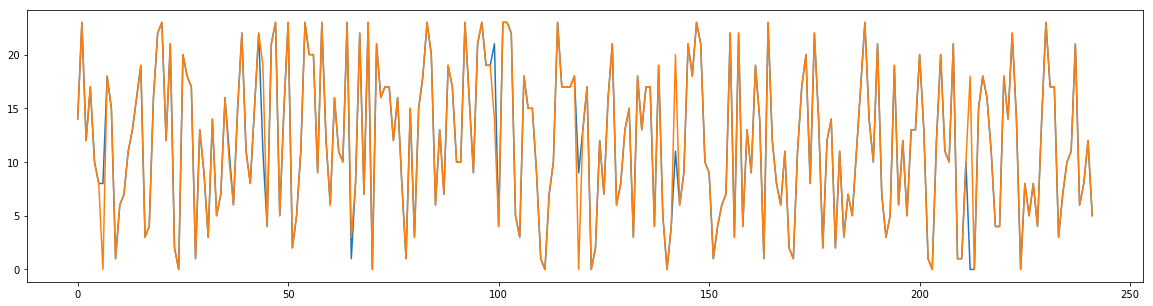

In [24]:
plt.figure(figsize=[20, 5])
plt.plot(preds)
plt.plot(ys)

In [25]:
trues = []
for i in range(24):
    trues.append(np.count_nonzero((preds == i) * (ys == i)))
trues = np.array(trues)
trues

array([ 8, 10,  6,  9, 10, 10, 10, 10, 10,  7, 10, 11, 10, 10,  9, 10,  9,
       15,  9,  7,  7, 10,  9, 18])

In [26]:
spieces = []
for i in range(24):
    spieces.append(np.count_nonzero(ys == i))
spieces = np.array(spieces)
spieces

array([10, 10,  6, 10, 10, 10, 10, 10, 10,  7, 11, 11, 10, 10, 10, 10,  9,
       15, 10,  8,  8, 10,  9, 18])

In [27]:
trues / spieces

array([0.8       , 1.        , 1.        , 0.9       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.90909091, 1.        , 1.        , 1.        , 0.9       ,
       1.        , 1.        , 1.        , 0.9       , 0.875     ,
       0.875     , 1.        , 1.        , 1.        ])

In [30]:
np.where(ys == 20)[0]

array([  6,  24,  70, 111, 119, 122, 140, 203, 213, 224])

In [31]:
valid_data.iloc[np.where(ys == 20)[0], :]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,name
6,00d442df7,0,1,19.3653,5906.25,20.1600,8250.0,/home/knikaido/work/Rainforest-Connection/data...
24,0ea8ea68a,0,1,3.8027,5906.25,4.5973,8250.0,/home/knikaido/work/Rainforest-Connection/data...
70,579db058c,0,1,36.2293,5906.25,37.5200,7500.0,/home/knikaido/work/Rainforest-Connection/data...
111,9496d86bf,0,1,40.5813,5906.25,41.8720,7500.0,/home/knikaido/work/Rainforest-Connection/data...
119,9c8947073,0,1,25.7653,5906.25,27.0560,7500.0,/home/knikaido/work/Rainforest-Connection/data...
122,9cb6ae5e3,0,1,39.7173,5906.25,40.5120,8250.0,/home/knikaido/work/Rainforest-Connection/data...
140,a54894b33,0,1,23.4240,5906.25,24.2187,8250.0,/home/knikaido/work/Rainforest-Connection/data...
203,d9bfc9e6b,0,1,56.8160,5906.25,57.6107,8250.0,/home/knikaido/work/Rainforest-Connection/data...
213,e25933b0a,0,1,17.6320,5906.25,18.4267,8250.0,/home/knikaido/work/Rainforest-Connection/data...
224,e9fa364b7,0,1,24.8853,5906.25,25.6800,8250.0,/home/knikaido/work/Rainforest-Connection/data...


In [32]:
np.where(preds == 0)[0]

array([ 24,  70, 111, 122, 140, 203, 212, 213, 224])

In [33]:
np.where((preds == 0) * (ys == 0))[0]

array([ 24,  70, 111, 122, 140, 203, 213, 224])

In [35]:
ys[212]

18